In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '/cndd2/fangming/projects/SingleCellRoutines')
from __init__scr import *
import utils
import powerplot

In [2]:
dirc = '/cndd2/fangming/projects/scf_enhancers/ABC-Enhancer-Gene-Prediction/mop_1-1-1/'
!ls $dirc

00.match_regions.sh
EnhancerList.bed
EnhancerList.txt
EnhancerPredictionsAllPutative.ForVariantOverlap.shrunk150bp.txt.gz
EnhancerPredictionsAllPutative.ForVariantOverlap.shrunk150bp.txt.gz.tmp
EnhancerPredictionsAllPutativeNonExpressedGenes.txt.gz
EnhancerPredictionsAllPutative.txt.gz
EnhancerPredictions.bedpe
EnhancerPredictionsFull.txt
EnhancerPredictions.txt
Enhancers.ATAC.1-1-1_sorted.bam.CountReads.bedgraph
enhs_list_chromsort.bed.1-1-1_sorted.bam.Counts.bed
enhs_list_chromsort.bed.candidateRegions.bed
GeneList.bed
GeneList.TSS1kb.bed
GeneList.txt
GenePredictionStats.txt
Genes.ATAC.1-1-1_sorted.bam.CountReads.bedgraph
Genes.TSS1kb.ATAC.1-1-1_sorted.bam.CountReads.bedgraph
newmid.bed
oldmid.bed
parameters.predict.txt
params.txt
regions_match.bed


In [3]:
f = '/cndd2/fangming/projects/scf_enhancers/ABC-Enhancer-Gene-Prediction/mop_1-1-1/regions_match.bed'
match = pd.read_csv(f, sep='\t', header=None)
match = match[[3,7,8]]
match.columns = ['abc', 'mine', 'd']
match = match.groupby('abc').first()

match

,mine,d
abc,,
chr10:100009482-100009982,chr10:100009732-100010967,617
chr10:100018280-100018780,chr10:100018530-100019593,531
chr10:100019354-100019854,chr10:100019604-100019864,130
chr10:100019945-100020445,chr10:100020195-100020328,66
chr10:100022162-100023049,chr10:100022412-100022744,27
...,...,...
chrX:99843574-99844074,chrX:99843824-99844135,155
chrX:99852936-99853436,chrX:99853186-99853303,58
chrX:9996944-9997444,chrX:9997194-9997721,263


In [4]:
# read
f = dirc+'/EnhancerPredictionsAllPutative.txt.gz'
abc = pd.read_csv(f, sep='\t')

# filter on distance
abc = abc[abc['distance']<1e5] #.shape

# match with old regions
_ = abc['chr']+":"+abc['start'].astype(str)+"-"+abc['end'].astype(str).values
abc['enh_name'] = match.loc[_, 'mine'].values

# categorize
default_th = 0.022
cond_sigabc = (abc['powerlaw.Score'] > default_th)
scorecat, bins = pd.qcut(abc['powerlaw.Score'][cond_sigabc], 3, retbins=True, labels=['1-low', '2-mid', '3-high'])
abc = abc.join(scorecat.to_frame('abc_cat'))

print(cond_sigabc.sum())
print(bins)

print(abc.columns)
print(abc.shape)
abc

64441
[0.022001 0.03412  0.062346 0.85957 ]
Index(['chr', 'start', 'end', 'name', 'class', 'activity_base', 'enh_midpoint',
       'enh_idx', 'TargetGene', 'TargetGeneTSS', 'TargetGeneExpression',
       'TargetGenePromoterActivityQuantile', 'TargetGeneIsExpressed',
       'gene_idx', 'distance', 'isSelfPromoter', 'powerlaw_contact',
       'powerlaw_contact_reference', 'powerlaw.Score.Numerator',
       'powerlaw.Score', 'CellType', 'enh_name', 'abc_cat'],
      dtype='object')
(208997, 23)


,chr,start,end,name,class,activity_base,enh_midpoint,enh_idx,TargetGene,TargetGeneTSS,...,gene_idx,distance,isSelfPromoter,powerlaw_contact,powerlaw_contact_reference,powerlaw.Score.Numerator,powerlaw.Score,CellType,enh_name,abc_cat
23,chr13,3523940,3524440,intergenic|chr13:3523940-3524440,intergenic,1.478002,3524190.0,92539,ENSMUSG00000097709,3478230,...,22809,45960.0,False,0.017920,0.017920,0.026486,0.042069,1-1-1,chr13:3524190-3524393,2-mid
24,chr13,3523940,3524440,intergenic|chr13:3523940-3524440,intergenic,1.478002,3524190.0,92539,ENSMUSG00000021218,3538063,...,22810,13873.0,False,0.050805,0.050805,0.075090,0.065540,1-1-1,chr13:3524190-3524393,3-high
25,chr13,3523940,3524440,intergenic|chr13:3523940-3524440,intergenic,1.478002,3524190.0,92539,ENSMUSG00000033799,3611108,...,22811,86918.0,False,0.010294,0.010294,0.015215,0.014399,1-1-1,chr13:3524190-3524393,NaN
45,chr13,3530145,3530645,intergenic|chr13:3530145-3530645,intergenic,0.682155,3530395.0,92540,ENSMUSG00000097709,3478230,...,22809,52165.0,False,0.016051,0.016051,0.010949,0.017391,1-1-1,chr13:3530395-3530548,NaN
46,chr13,3530145,3530645,intergenic|chr13:3530145-3530645,intergenic,0.682155,3530395.0,92540,ENSMUSG00000021218,3538063,...,22810,7668.0,False,0.085094,0.085094,0.058047,0.050665,1-1-1,chr13:3530395-3530548,2-mid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9634898,chr1,195028450,195028950,intergenic|chr1:195028450-195028950,intergenic,0.611097,195028700.0,10884,ENSMUSG00000016494,194938819,...,1733,89881.0,False,0.009998,0.009998,0.006110,0.002088,1-1-1,chr1:195028700-195028788,NaN
9634899,chr1,195028450,195028950,intergenic|chr1:195028450-195028950,intergenic,0.611097,195028700.0,10884,ENSMUSG00000097325,194976960,...,1734,51740.0,False,0.016165,0.016165,0.009879,0.004257,1-1-1,chr1:195028700-195028788,NaN
9634900,chr1,195028450,195028950,intergenic|chr1:195028450-195028950,intergenic,0.611097,195028700.0,10884,ENSMUSG00000104206,194995345,...,1735,33355.0,False,0.023684,0.023684,0.014473,0.006926,1-1-1,chr1:195028700-195028788,NaN
9634901,chr1,195028450,195028950,intergenic|chr1:195028450-195028950,intergenic,0.611097,195028700.0,10884,ENSMUSG00000104077,195018242,...,1736,10458.0,False,0.064963,0.064963,0.039699,0.022626,1-1-1,chr1:195028700-195028788,1-low


In [5]:
abc.groupby('class').size()

class
genic         132819
intergenic     74500
promoter        1678
dtype: int64

# Compare with my predictions 

In [6]:
import sys
import importlib
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')
sys.path.insert(0, '/cndd2/fangming/projects/scf_enhancers/scripts/scf_enhancer_paper')
from __init__ import *
import __init__jupyterlab
importlib.reload(__init__jupyterlab)
from __init__jupyterlab import *

import re 
import tqdm
import pickle
import collections
import itertools
import tables

from scipy import sparse
from scipy import stats
from scipy import optimize 
import scipy.cluster.hierarchy as sch
from statsmodels.stats.multitest import multipletests

import snmcseq_utils
importlib.reload(snmcseq_utils)
import CEMBA_clst_utils
importlib.reload(CEMBA_clst_utils)
import enhancer_gene_utils 
importlib.reload(enhancer_gene_utils)

<module 'enhancer_gene_utils' from '/cndd2/fangming/projects/scf_enhancers/scripts/scf_enhancer_paper/enhancer_gene_utils.py'>

In [7]:
import datetime
today = datetime.date.today().strftime("%y%m%d")

CORRCOEF_TYPE = 'Spearmanr' # Pearsonr
print(today)

210721


# README

Fixed inputs:
- enhancer list **check**
    - enhancer nearest genes
    - enhancer CICERO
- gene list **check**
- enh-gene pair list **check**

Picked inputs:
- corrs_mc **check**
- corrs_atac **check**

outputs:
- plots and stats of corrs_mc and corrs_atac


## How are corrs_mc and corrs_atac calculated?
- pairs: ```/cndd2/fangming/projects/scf_enhancers/results/200521_to_evals.tsv```
- matrices (genes, enhs, matrices): ```/cndd2/fangming/projects/scf_enhancers/data/organized_cell_level/version_nov9```
- knns: ```/cndd2/fangming/projects/miniatlas/results```


## How are other inputs for this notebook generated?
-  ```01.preproc_data_10xv3cells_r100_n935-Dec12.ipynb```
-  ```./correlation_analysis_celllevel/correlation_analysis_celllevel_organize_data-10xv3cells.ipynb```

# config

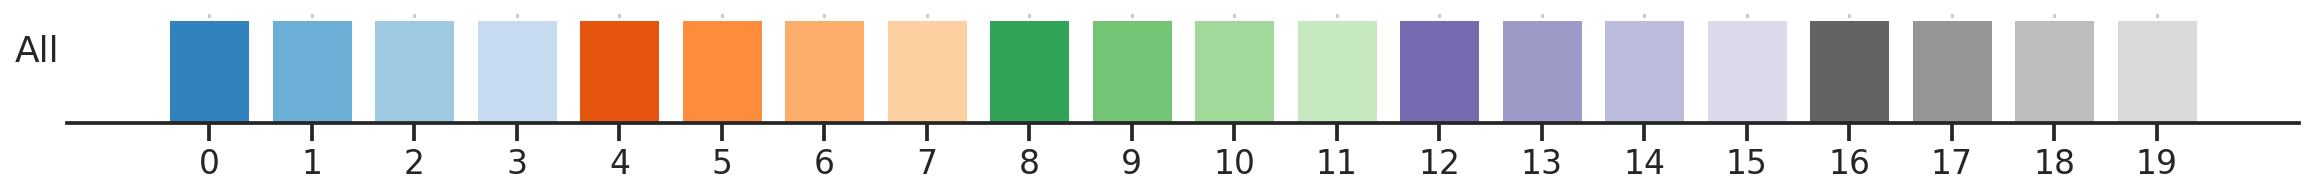

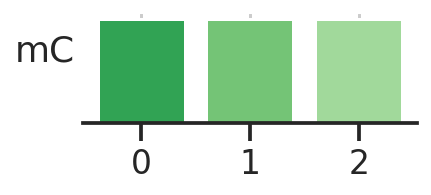

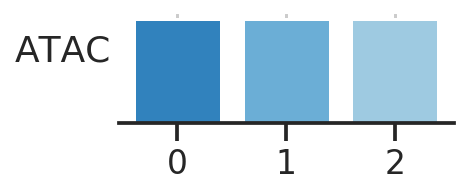

/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/matplotlib/colors.py:235: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


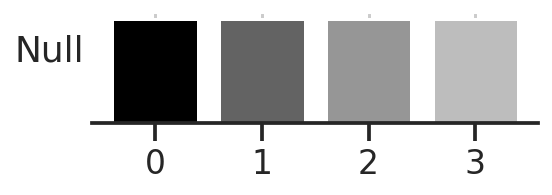

In [8]:
# color palette
cm = plt.cm.tab20c.colors

# settle down on a color palette
colors_mc = [cm[8], cm[9], cm[10],]
colors_atac = [cm[0], cm[1], cm[2],]
colors_null = ['black', cm[16], cm[17], cm[18],]

color_tracks = [
    cm,
    colors_mc,
    colors_atac,
    colors_null,
]

labels = [
    'All',
    'mC',
    'ATAC',
    'Null',
]

for color_track, label in zip(color_tracks, labels):
    n = len(color_track)
    fig, ax = plt.subplots(figsize=(1*n,1))
    ax.bar(np.arange(n), 1, 
           color=color_track)
    ax.set_xticks(np.arange(n))
    ax.set_ylabel(label, rotation=0, ha='right')
    sns.despine(ax=ax, left=True)
    ax.set_yticks([])
    plt.show()

In [9]:
mod_palette = {
    'mc': 'C2',
    'atac': 'C0',
    'null': 'k',
}

mod_palette_comp = {
    'mc': colors_mc,
    'atac': colors_atac,
    'null': colors_null,
}

KB = 1000
def p25(x):
    return np.nanpercentile(x, 25)
def p75(x):
    return np.nanpercentile(x, 75)

In [10]:
def strip_gid_suffix(gid):
    """
    """
    if isinstance(gid, str):
        gid_new = gid.split('.')[0]
    else:
        gid_new = ''
    return gid_new

# data 
- caveats - 
- the genes, enhs, pairs list here may be incomplete; 
- they are tailored to cluster38 version

In [11]:
# genes
# enhs
# to_evals
f = '/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/organized_for_jupyter/genes_list.tsv'
genes_list = pd.read_csv(f, sep='\t', index_col=False)
print(genes_list.shape)

# enh list
f = '/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/organized_for_jupyter/enhs_list.tsv'
enh_list = pd.read_csv(f, sep='\t', index_col=False)
print(enh_list.shape)

# pair list
f = '/cndd2/fangming/projects/scf_enhancers/results/200521_to_evals_appended_201212.tsv' 
to_evals = pd.read_csv(f, sep='\t', index_col=False)
to_evals = to_evals.astype({'dist': np.int, 'enh': np.int, 'is_in_genebody': np.bool_})

print(to_evals.shape)

(31053, 11)
(233514, 7)


/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(2589994, 4)


<ipython-input-11-0047111e1422>:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  to_evals = to_evals.astype({'dist': np.int, 'enh': np.int, 'is_in_genebody': np.bool_})


In [12]:
to_evals.head()

,gene,enh,dist,is_in_genebody
0,ENSMUSG00000000001,147520,995118,False
1,ENSMUSG00000000001,147522,985740,False
2,ENSMUSG00000000001,147523,983725,False
3,ENSMUSG00000000001,147527,970444,False
4,ENSMUSG00000000001,147528,969372,False


In [13]:
gid_to_gname = genes_list.groupby('gid').first()['gene_name'] 
gname_to_gid = genes_list.groupby('gene_name').first()['gid']

def gname_to_gid_nan(name):
    try:
        return gname_to_gid[name]
    except:
        return np.nan

In [14]:
f = '/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/organized_for_jupyter/enhancer_nearest_genes.bed'
regions_info = pd.read_csv(f, sep='\t', header=None, dtype={0: str, 4: str}, 
                           names=['chr', 'start', 'end', 
                                  'trpt_chr', 'trpt_start', 'trpt_end', 
                                  'strand', 
                                  'trpt_id', 'trpt_name',
                                  'gene_id', 'gene_name',
                                  'dist',
                                 ]
                          )

print(regions_info.shape)
print(enh_list.shape)
# expand enh_list
enh_list_expand = pd.merge(enh_list, regions_info, on=['chr', 'start', 'end'], how='left')
enh_list_expand['name'] = enh_list_expand['chr']+':'+enh_list_expand['start'].astype(str)+"-"+enh_list_expand['end'].astype(str)
print(enh_list_expand.shape)
enh_list_expand.head()

(233514, 12)
(233514, 7)
(233514, 17)


,index,chr,start,end,length,chrom,center,trpt_chr,trpt_start,trpt_end,strand,trpt_id,trpt_name,gene_id,gene_name,dist,name
0,0,chr1,3083769,3083816,47,1,3083792,chr1,3073253,3073254,+,ENSMUST00000193812.1,4933401J01Rik-201,ENSMUSG00000102693.1,4933401J01Rik,10516,chr1:3083769-3083816
1,1,chr1,3112234,3112467,233,1,3112350,chr1,3102016,3102017,+,ENSMUST00000082908.1,Gm26206-201,ENSMUSG00000064842.1,Gm26206,10218,chr1:3112234-3112467
2,2,chr1,3112770,3112986,216,1,3112878,chr1,3102016,3102017,+,ENSMUST00000082908.1,Gm26206-201,ENSMUSG00000064842.1,Gm26206,10754,chr1:3112770-3112986
3,3,chr1,3113717,3114035,318,1,3113876,chr1,3102016,3102017,+,ENSMUST00000082908.1,Gm26206-201,ENSMUSG00000064842.1,Gm26206,11701,chr1:3113717-3114035
4,4,chr1,3118790,3118935,145,1,3118862,chr1,3102016,3102017,+,ENSMUST00000082908.1,Gm26206-201,ENSMUSG00000064842.1,Gm26206,16774,chr1:3118790-3118935


In [15]:
# cicero pairs
## enh <-> cicero enh
f = '/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/organized_for_jupyter/enhancer_cicero_overlap.bed'
enh_cicero_overlap = pd.read_csv(f, sep='\t', 
                                 names=['chr', 'start', 'end', 
                                        'cicero_chr', 'cicero_start', 'cicero_end',
                                        'overlap',
                                       ]) 
print(enh_cicero_overlap.shape)
# restrict to the enhancers in this study
enh_cicero_overlap = pd.merge(enh_cicero_overlap, enh_list[['chr', 'start', 'end', 'index']], 
                                 on=['chr', 'start', 'end'])
print(enh_cicero_overlap.shape)


## cicero enh <-> cicero gene
f = '/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/ref/cicero_enhancer_gene_mm10_chr.bed'
cicero_gene_links = pd.read_csv(f, sep='\t', 
                                names=['cicero_chr', 'cicero_start', 'cicero_end', 'cicero_idx', 'cicero_gene']
                               ) 
# restrict to genes in this study
cicero_gene_links['cicero_gid'] = cicero_gene_links['cicero_gene'].apply(gname_to_gid_nan)
print(cicero_gene_links.shape)
cicero_gene_links = cicero_gene_links.dropna()
print(cicero_gene_links.shape)


## merge for enh <-> gene (cicero) (register into the current gene-enh pairs (index))
enh_gene_links_cicero = pd.merge(enh_cicero_overlap, cicero_gene_links, 
                                 on=['cicero_chr', 'cicero_start', 'cicero_end'])
enh_gene_links_cicero = enh_gene_links_cicero[['index', 'cicero_gid']].rename(
                            columns={'cicero_gid': 'gene', 'index': 'enh',})
enh_gene_links_cicero = (pd.merge(enh_gene_links_cicero, to_evals[['gene', 'enh']].reset_index(), 
                                  on=['enh', 'gene']) 
                                .groupby('index').first() # remove dup 
                        )
print(enh_cicero_overlap.shape, 
      cicero_gene_links.shape, 
      enh_gene_links_cicero.shape,
     )
enh_gene_links_cicero.head()

(102287, 7)
(102287, 8)
(1283006, 6)
(990207, 6)
(102287, 8) (990207, 6) (305768, 2)


,enh,gene
index,,
65,147620,ENSMUSG00000000001
68,147628,ENSMUSG00000000001
72,147634,ENSMUSG00000000001
74,147637,ENSMUSG00000000001
76,147643,ENSMUSG00000000001


# Analysis 

In [16]:

# get all clusterings
def get_isub_clstfile(fname):
    """Subsampling index
    """
    pattern = '_sub[0-9]+.tsv.gz' 
    isub = int(re.findall(pattern, fname)[0][len("_sub"):-len('.tsv.gz')])
    return isub 

def get_knn_clstfile(fname):
    """cross-modal knn
    """
    pattern = '_knn[0-9]+_' 
    knn = int(re.findall(pattern, fname)[0][len("_knn"):-len('_')])
    return knn 

f_pattern = ("/cndd2/fangming/projects/miniatlas/results/"
             "clusterings_10x_cells_v3_mop_10x_cells_v3_snatac_gene_ka30_knn*_201206_sub*.tsv.gz"
             )
fnames = np.sort(glob.glob(f_pattern))
iterator_clsts = pd.DataFrame([{'i': get_isub_clstfile(fname),
                                'k': get_knn_clstfile(fname),
                                'fname': fname,
                              } for fname in fnames])
print(iterator_clsts.shape)

res_clsts = []
for idx, row in tqdm.tqdm(iterator_clsts.iterrows()):
    isub = row['i']
    knn = row['k']
    fname = row['fname']
    
    df = pd.read_csv(fname, index_col=0, sep='\t')
    for col in df.columns:
        r = float(col[len('cluster_r'):])
        num_clst = len(df[col].unique())
        res_clsts.append({
            'k': knn,
            'i': isub,
            'r': r,
            'num_clst': num_clst,
        })
#     break
res_clsts = pd.DataFrame(res_clsts)

print(res_clsts.shape)
res_clsts.head()

0it [00:00, ?it/s]

(1, 3)


1it [00:00,  2.67it/s]

(41, 4)


,k,i,r,num_clst
0,30,0,1.000000,16
1,30,0,1.258925,18
2,30,0,1.584893,22
3,30,0,1.995262,28
4,30,0,2.511886,34


In [17]:
# get all (shared) corr analyses
def get_resolution(fname):
    """Resolution
    """
    resolution_pattern = '_cluster_r[0-9.]+_' 
    r = float(re.findall(resolution_pattern, fname)[0][len("_cluster_r"):-len('_')])
    return r
    
def get_isub(fname):
    """Subsampling index
    """
    pattern = '_[0-9]_cluster' 
    isub = int(re.findall(pattern, fname)[0][len("_"):-len('_cluster')])
    return isub 

def get_knn(fname):
    """cross-modal knn
    """
    pattern = '_knn[0-9]+_' 
    knn = int(re.findall(pattern, fname)[0][len("_knn"):-len('_')])
    return knn 

# mC
f_pattern = ("/cndd2/fangming/projects/scf_enhancers/results/"
             "mop_10x_cells_v3_snmcseq_gene_ka30_knn*_201206"
             "_[0-9]_cluster_r*_spearmanr_corrs.pkl"
            )
fnames = np.sort(glob.glob(f_pattern))
iterator_mc = pd.DataFrame([{'r': get_resolution(fname),
                             'i': get_isub(fname),
                             'k': get_knn(fname),
                             'fname_mc': fname,
                          } for fname in fnames])
print(iterator_mc.shape)

# ATAC
f_pattern = ("/cndd2/fangming/projects/scf_enhancers/results/"
             "mop_10x_cells_v3_snatac_gene_ka30_knn*_201206"
             "_[0-9]_cluster_r*_spearmanr_corrs.pkl"
            )
fnames = np.sort(glob.glob(f_pattern))
iterator_atac = pd.DataFrame([{'r': get_resolution(fname),
                               'i': get_isub(fname),
                               'k': get_knn(fname),
                               'fname_atac': fname,
                              } for fname in fnames])
print(iterator_atac.shape)

# both
iterator_both = pd.merge(iterator_mc, iterator_atac, on=['k', 'r', 'i'])
print(iterator_both.shape)
iterator_both.head()

(30, 4)
(21, 4)
(21, 5)


,r,i,k,fname_mc,fname_atac
0,1.000000,0,30,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...
1,1.258925,0,30,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...
2,1.584893,0,30,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...
3,1.995262,0,30,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...
4,10.000000,0,30,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...


(21, 6)


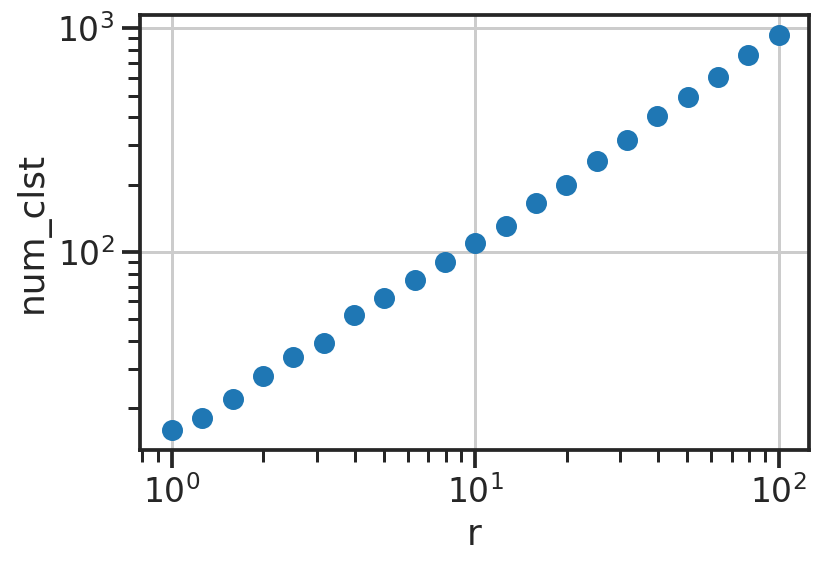

,r,num_clst
0,1.000000,16
1,1.258925,18
2,1.584893,22
3,1.995262,28
9,2.511886,34
11,3.162278,39
12,3.981072,52
15,5.011872,62
17,6.309573,75
19,7.943282,90


In [18]:
iterator_both = pd.merge(iterator_both, res_clsts)
print(iterator_both.shape)
iterator_both.head()

fig, ax = plt.subplots()
_x = iterator_both['r']
_y = iterator_both['num_clst']
ax.scatter(_x, _y)
ax.set_xlabel('r')
ax.set_ylabel('num_clst')
ax.set_yscale("log")
ax.set_xscale("log")
plt.show()

iterator_both[['r', 'num_clst']].sort_values('r')

# one analysis 

In [19]:
# choose 1 (r=100; num_clst=935) to proceed 
num_clst = 256
fname1, fname2, resolution = iterator_both[iterator_both['num_clst']==num_clst][['fname_mc', 'fname_atac', 'r']].iloc[0]

print(fname1)
print(fname2)

output_figures = '/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/figures/fig2_metacell_{}_r{:.1f}_n{}_{{}}'.format(today, resolution, num_clst)
output_results = '/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/results_new/fig2_metacell_{}_r{:.1f}_n{}_{{}}'.format(today, resolution, num_clst)
print(output_figures)
print(output_results)



/cndd2/fangming/projects/scf_enhancers/results/mop_10x_cells_v3_snmcseq_gene_ka30_knn30_201206_0_cluster_r25.11886431509581_spearmanr_corrs.pkl
/cndd2/fangming/projects/scf_enhancers/results/mop_10x_cells_v3_snatac_gene_ka30_knn30_201206_0_cluster_r25.11886431509581_spearmanr_corrs.pkl
/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/figures/fig2_metacell_210721_r25.1_n256_{}
/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/results_new/fig2_metacell_210721_r25.1_n256_{}


In [20]:
## organize data; get results
# get corrs
with open(fname1, 'rb') as fh:
    to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells = pickle.load(fh)
res_corrs = to_evals[to_correlate].copy()
res_corrs['corr'] = corrs 
res_corrs['corr_shuff'] = corrs_shuffled
res_corrs['corr_shuff_cells'] = corrs_shuffled_cells

print(res_corrs.shape)
res_corrs.head()

(2340530, 7)


,gene,enh,dist,is_in_genebody,corr,corr_shuff,corr_shuff_cells
0,ENSMUSG00000000001,147520,995118,False,0.033872,0.102645,-0.046980
1,ENSMUSG00000000001,147522,985740,False,0.143464,-0.032722,-0.089526
2,ENSMUSG00000000001,147523,983725,False,0.018830,-0.038517,-0.040161
3,ENSMUSG00000000001,147527,970444,False,-0.149245,-0.121492,0.031340
4,ENSMUSG00000000001,147528,969372,False,-0.237863,-0.015748,0.068727


In [21]:
with open(fname2, 'rb') as fh:
    to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells = pickle.load(fh)
res2_corrs = to_evals[to_correlate].copy()
res2_corrs['corr'] = corrs 
res2_corrs['corr_shuff'] = corrs_shuffled
res2_corrs['corr_shuff_cells'] = corrs_shuffled_cells

print(res_corrs.shape)
res_corrs.head()

(2340530, 7)


,gene,enh,dist,is_in_genebody,corr,corr_shuff,corr_shuff_cells
0,ENSMUSG00000000001,147520,995118,False,0.033872,0.102645,-0.046980
1,ENSMUSG00000000001,147522,985740,False,0.143464,-0.032722,-0.089526
2,ENSMUSG00000000001,147523,983725,False,0.018830,-0.038517,-0.040161
3,ENSMUSG00000000001,147527,970444,False,-0.149245,-0.121492,0.031340
4,ENSMUSG00000000001,147528,969372,False,-0.237863,-0.015748,0.068727


In [22]:
# mean pattern
n = 100
_dists = np.linspace(2*KB, 1000*KB, n)
res_corrs_median = res_corrs.groupby(pd.cut(res_corrs['dist'], _dists)).agg([np.median, 
                                                                             np.mean, 
                                                                             p25,
                                                                             p75,
                                                                            ])
res2_corrs_median = res2_corrs.groupby(pd.cut(res2_corrs['dist'], _dists)).agg([np.median, 
                                                                             np.mean, 
                                                                             p25,
                                                                             p75,
                                                                            ])

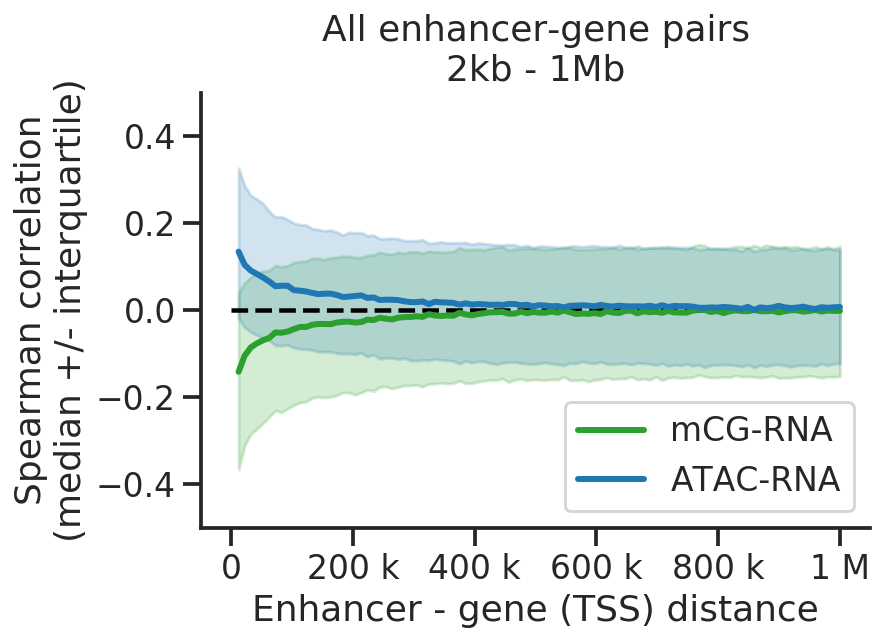

In [23]:
fig, ax = plt.subplots(figsize=(6,4))

_x = _dists[1:]
ax.hlines(0, 0, np.max(_x), linestyle='--')

_y = res_corrs_median['corr']['median'].values
_ylow = res_corrs_median['corr']['p25'].values
_yhigh = res_corrs_median['corr']['p75'].values
ax.plot(_x, _y, 
        label='mCG-RNA',
        linewidth=3,
        color=mod_palette['mc'])
ax.fill_between(_x, _ylow, _yhigh, color=mod_palette['mc'], alpha=0.2, 
#                 label='mCG interquartile',
               )
sns.despine(ax=ax)

_y = res2_corrs_median['corr']['median'].values
_ylow = res2_corrs_median['corr']['p25'].values
_yhigh = res2_corrs_median['corr']['p75'].values
ax.plot(_x, _y, 
        label='ATAC-RNA',
        linewidth=3,
        color=mod_palette['atac'])
ax.fill_between(_x, _ylow, _yhigh, color=mod_palette['atac'], alpha=0.2, 
#                 label='ATAC interquartile',
               )
sns.despine(ax=ax)
ax.grid(False)

ax.set_title('All enhancer-gene pairs\n2kb - 1Mb')
ax.set_ylabel('Spearman correlation\n(median +/- interquartile)')
ax.set_xlabel('Enhancer - gene (TSS) distance')
# ax.legend(bbox_to_anchor=(1,1), loc='upper left')
ax.legend(bbox_to_anchor=(1,0), loc='lower right')
ax.xaxis.set_major_formatter(mtick.EngFormatter())
ax.set_ylim([-0.5, 0.5])

fig.savefig(output_figures.format('line_corr_dist.pdf'), bbox_inches='tight')
plt.show()

In [24]:
# fitting -- the two different results are due to two different weights
def ffit(x, a, b):
    """
    """
    y = a*np.exp(-b*x)
    return y

def linear_fit(x, a, b):
    y = a*x+b
    return y

_x = _dists[1:]
_y1 = res_corrs_median['corr']['median'].values
_y2 = res2_corrs_median['corr']['median'].values

_x1 = _x[_y1<0]
_y1 = _y1[_y1<0]

_x2 = _x[_y2>0]
_y2 = _y2[_y2>0]

resfit = optimize.curve_fit(ffit, _x1/KB, -_y1)
((a, b), _) = resfit
print(-b, np.log(a))

resfit = optimize.curve_fit(ffit, _x2/KB, _y2)
((a, b), _) = resfit
print(-b, np.log(a))

resfit = optimize.curve_fit(linear_fit, _x1/KB, np.log(-_y1))
((a, b), _) = resfit
print(a, b)

resfit = optimize.curve_fit(linear_fit, _x2/KB, np.log(_y2))
((a, b), _) = resfit
print(a, b)

-0.007993189155243748 -2.1451539264074513
-0.0056215535638808566 -2.2635961433710587
-0.004228014978118227 -2.818216392707072
-0.0027730191563439715 -2.895698336832758


<ipython-input-24-6eac16f2f9e9>:5: RuntimeWarning: overflow encountered in exp
  y = a*np.exp(-b*x)


<ipython-input-24-6eac16f2f9e9>:5: RuntimeWarning: overflow encountered in exp
  y = a*np.exp(-b*x)


0.117050018568552 0.007993189155243748 86.71722476443861
0.10397589938577897 0.0056215535638808566 123.30171236177442
/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/figures/fig2_metacell_210721_r25.1_n256_corr_distance_decay_fit.pdf


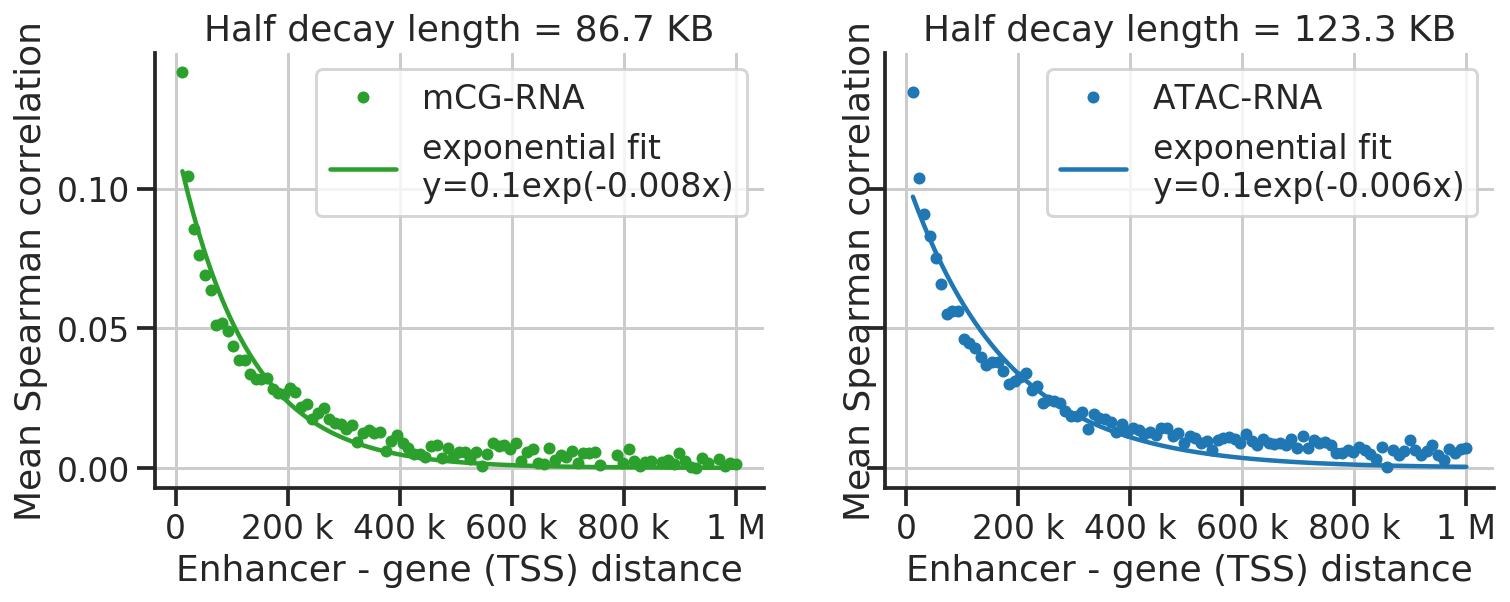

In [25]:
# ... 
output = output_figures.format('corr_distance_decay_fit.pdf')

_x = _dists[1:]
_y1 = res_corrs_median['corr']['median'].values
_y2 = res2_corrs_median['corr']['median'].values

_x1 = _x[_y1<0]
_y1 = _y1[_y1<0]

_x2 = _x[_y2>0]
_y2 = _y2[_y2>0]


resfit = optimize.curve_fit(ffit, _x1/KB, -_y1)
((a1, b1), _) = resfit
print(a1, b1, np.log(2)/b1)

resfit = optimize.curve_fit(ffit, _x2/KB, _y2)
((a2, b2), _) = resfit
print(a2, b2, np.log(2)/b2)

s = 5
fig, axs = plt.subplots(1, 2, figsize=(6*2,4), sharex=True, sharey=True)
ax = axs[0]
ax.plot(_x1, -_y1, 'o', color=mod_palette['mc'], label='mCG-RNA', markersize=s)
ax.plot(_x1, ffit(_x1/KB, a1, b1), color=mod_palette['mc'], label='exponential fit\ny={:.1}exp(-{:.1}x)'.format(a1, b1))
ax.xaxis.set_major_formatter(mtick.EngFormatter())
sns.despine(ax=ax)
ax.legend()
ax.set_title('Half decay length = {:.1f} KB'.format(np.log(2)/b1))

# ax.set_yscale('log')
ax.set_ylabel('Mean Spearman correlation')
ax.set_xlabel('Enhancer - gene (TSS) distance')

ax = axs[1]
ax.plot(_x2, _y2, 'o', color=mod_palette['atac'], label='ATAC-RNA', markersize=s)
ax.plot(_x2, ffit(_x2/KB, a2, b2), color=mod_palette['atac'], label='exponential fit\ny={:.1}exp(-{:.1}x)'.format(a2, b2))
ax.xaxis.set_major_formatter(mtick.EngFormatter())
sns.despine(ax=ax)
ax.legend()
ax.set_title('Half decay length = {:.1f} KB'.format(np.log(2)/b2))

ax.set_ylabel('Mean Spearman correlation')
ax.set_xlabel('Enhancer - gene (TSS) distance')


print(output)
snmcseq_utils.savefig(fig, output)

plt.show()

### Statistical evaluation 

In [26]:
fdr = 0.2
dist_th = 1e5 # 100kb
# pval_type_shuffled, pval_type_shuffled_cells = 'left', 'both'
pval_type_shuffled, pval_type_shuffled_cells = 'left', 'both'
nbins = 501

res_stats = enhancer_gene_utils.get_significance_stats(
                            res_corrs[['gene', 'enh', 'dist']],
                            res_corrs['corr'],
                            res_corrs['corr_shuff'],
                            res_corrs['corr_shuff_cells'],
                            pval_type_shuffled, pval_type_shuffled_cells,
                            bins=np.linspace(-1,1,nbins),
                            distance_threshold=dist_th,
                            fdr_threshold=fdr,
                            positive_side=False,
                            return_pval=True,
                            return_cdf=False,
                        )
res2_stats = enhancer_gene_utils.get_significance_stats(
                            res2_corrs[['gene', 'enh', 'dist']],
                            res2_corrs['corr'],
                            res2_corrs['corr_shuff'],
                            res2_corrs['corr_shuff_cells'],
                            pval_type_shuffled, pval_type_shuffled_cells,
                            bins=np.linspace(-1,1,nbins),
                            distance_threshold=dist_th,
                            fdr_threshold=fdr,
                            positive_side=True,
                            return_pval=True,
                            return_cdf=False,
                        )
print(list(res_stats.keys()))
print(list(res2_stats.keys()))

['dist_th', 'num_total_pairs', 'num_total_genes', 'num_total_enhs', 'r_th_linked', 'r_th_linked_left', 'r_th_linked_right', 'r_th_correlated_left', 'r_th_correlated_right', 'num_linked_pairs', 'num_linked_genes', 'num_linked_enhs', 'linked_table', 'num_correlated_pairs', 'num_correlated_genes', 'num_correlated_enhs', 'correlated_table', 'bins', 'linked_pval', 'correlated_pval']
['dist_th', 'num_total_pairs', 'num_total_genes', 'num_total_enhs', 'r_th_linked', 'r_th_linked_left', 'r_th_linked_right', 'r_th_correlated_left', 'r_th_correlated_right', 'num_linked_pairs', 'num_linked_genes', 'num_linked_enhs', 'linked_table', 'num_correlated_pairs', 'num_correlated_genes', 'num_correlated_enhs', 'correlated_table', 'bins', 'linked_pval', 'correlated_pval']


In [27]:
# # save some results
# output = output_results.format('corr_results.pkl')
# print(output)

# with open(output, 'wb') as fh:
#     pickle.dump((to_evals, 
#                  res_corrs, res2_corrs, 
#                  res_stats, res2_stats,
#                 ), fh)

# save some results
output = output_results.format('linked_pairs_mc.tsv')
print(output)
res_stats['linked_table'].to_csv(output, sep="\t", header=True, index=False)
output = output_results.format('linked_pairs_atac.tsv')
res2_stats['linked_table'].to_csv(output, sep="\t", header=True, index=False)

output = output_results.format('correlated_pairs_mc.tsv')
print(output)
res_stats['correlated_table'].to_csv(output, sep="\t", header=True, index=False)
output = output_results.format('correlated_pairs_atac.tsv')
res2_stats['correlated_table'].to_csv(output, sep="\t", header=True, index=False)

/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/results_new/fig2_metacell_210721_r25.1_n256_linked_pairs_mc.tsv
/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/results_new/fig2_metacell_210721_r25.1_n256_correlated_pairs_mc.tsv


# Venn diagrams
- compare different sets: mC, ATAC, CICERO
- linked, correlated

In [28]:
from matplotlib_venn import venn2
from matplotlib_venn import venn3

def venn_ax(ax, title, sets, set_labels, set_colors, 
            intformat=True,
             **kwargs):
    """
    venn2 or venn3
    kwargs include: normalize_to
    """
    if len(sets) == 3:
        out = venn3(sets,
                    set_labels=set_labels,
                    set_colors=set_colors,
                    ax=ax,
                    **kwargs,
                   )
    elif len(sets) == 2:
        out = venn2(sets,
                    set_labels=set_labels,
                    set_colors=set_colors,
                    ax=ax,
                    **kwargs,
                   )
    ax.set_title(title)
    
    if intformat:
        for text in out.subset_labels:
            text.set_text("{:,}".format(int(text.get_text())))
            text.set_fontsize(10)
    return out

/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/figures/fig2_metacell_210721_r25.1_n256_venn_pairs_linked_cicero.pdf


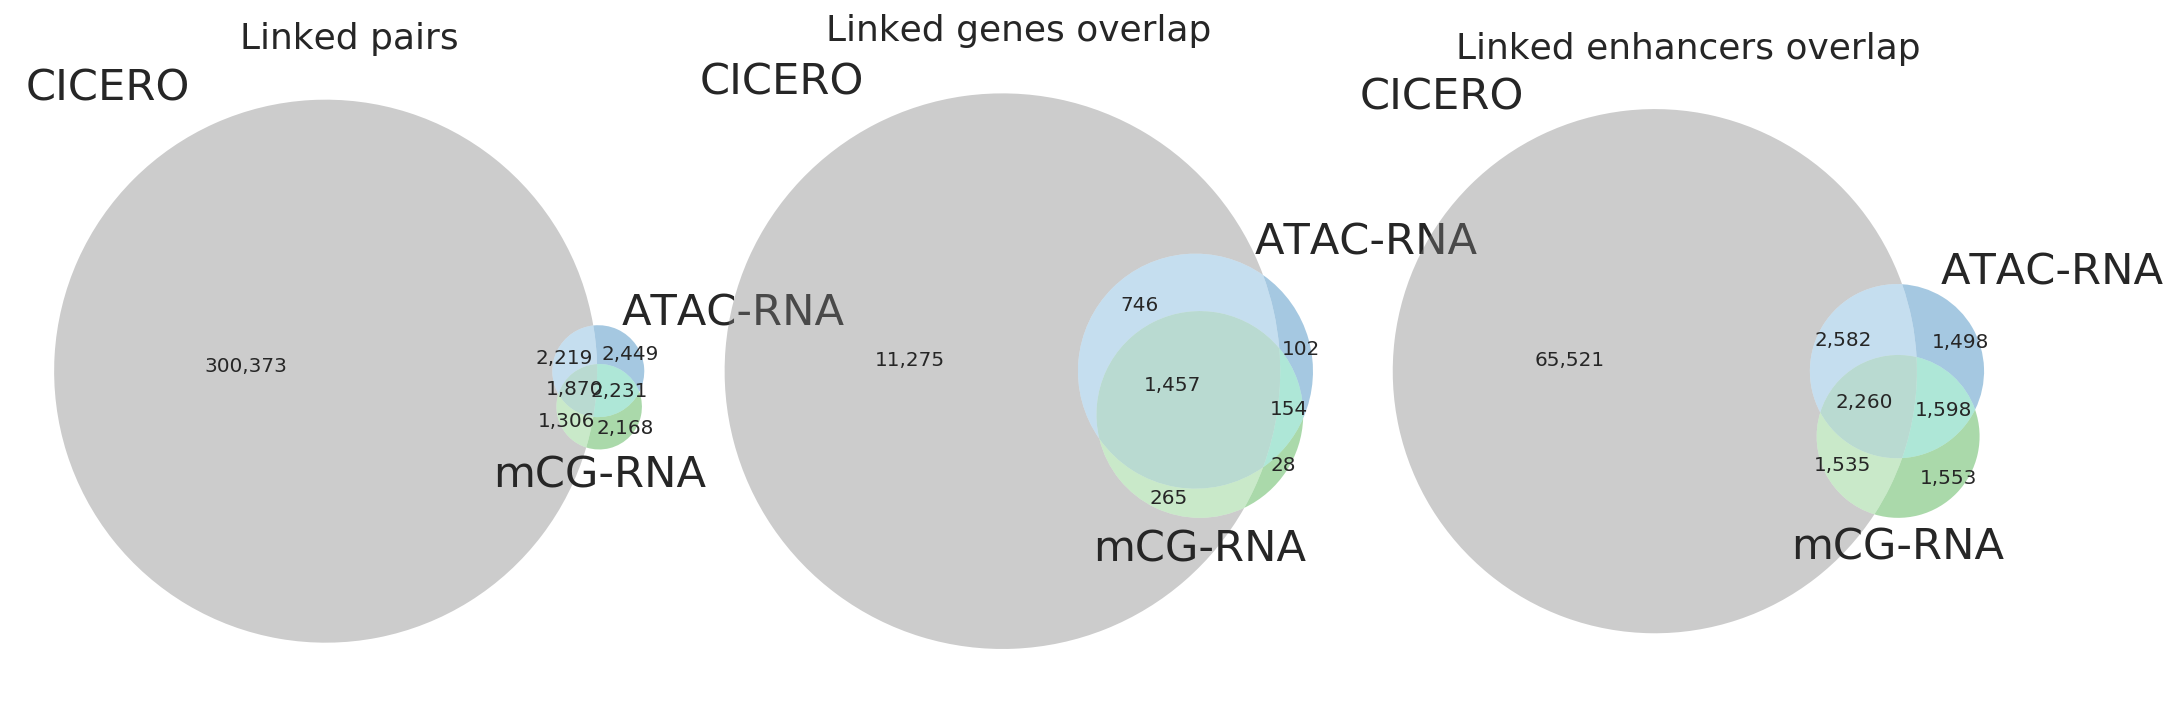

In [29]:
output = output_figures.format('venn_pairs_linked_cicero.pdf')

sets = [
    [
        set(enh_gene_links_cicero.index.values),
        set(res2_stats['linked_table'].index.values),
        set(res_stats['linked_table'].index.values), 
    ],
    [
        set(enh_gene_links_cicero['gene'].values),
        set(res2_stats['linked_table']['gene'].values),
        set(res_stats['linked_table']['gene'].values), 
    ],
    [
        set(enh_gene_links_cicero['enh'].values),
        set(res2_stats['linked_table']['enh'].values),
        set(res_stats['linked_table']['enh'].values),
    ],
]
sets_titles = ['Linked pairs', 'Linked genes overlap', 'Linked enhancers overlap']
set_labels=['CICERO', 'ATAC-RNA', 'mCG-RNA']
set_colors=['gray', mod_palette['atac'], mod_palette['mc']]

fig, axs = plt.subplots(1, 3, figsize=(3*6, 1*6))
for i, (ax, title) in enumerate(zip(
    axs, sets_titles)):
    
    out = venn_ax(ax, title, sets[i], set_labels, set_colors,
                 normalize_to=1.5,
                 )
    
#     true_area = len(sets[i][0]|sets[i][1]|sets[i][2])
#     ref_area = len(sets[0][0]|sets[0][1]|sets[0][2])
#     enhancer_gene_utils.set_venn_scale(ax, true_area, ref_area)

fig.subplots_adjust(wspace=0)
print(output)
snmcseq_utils.savefig(fig, output)

In [30]:
# add enh_name column to tables # old results
enh_list_expand['enh_name'] = enh_list_expand['chr']+":"+enh_list_expand['start'].astype(str)+"-"+enh_list_expand['end'].astype(str)
res2_stats['linked_table']['enh_name'] = enh_list_expand.set_index('index').loc[res2_stats['linked_table']['enh']]['enh_name'].values
res2_corrs['enh_name'] = enh_list_expand.set_index('index').loc[res2_corrs['enh']]['enh_name'].values

In [31]:
# genes
g_old = res2_stats['linked_table']['gene'].unique()
g_new = abc['TargetGene'].unique()
common_genes = np.intersect1d(g_old, g_new)
print(g_old.shape, g_new.shape, common_genes.shape)

# enhancers
e_old = res2_stats['linked_table']['enh_name'].unique()
e_new = abc['enh_name'].unique()
common_enhs = np.intersect1d(e_old, e_new)
print(e_old.shape, e_new.shape, common_enhs.shape)

(2459,) (17533,) (2232,)
(7938,) (83881,) (5572,)


In [32]:
# mine = pd.merge(res2_stats['linked_table'], res2_corrs, on=['gene', 'enh', 'dist'], how='left')
# mine

merged = pd.merge(
    res2_corrs, 
    abc[['TargetGene', 'enh_name', 'powerlaw.Score']].rename(columns={'TargetGene': 'gene'}),
    on=['gene', 'enh_name'],
    )
merged

,gene,enh,dist,is_in_genebody,corr,corr_shuff,corr_shuff_cells,enh_name,powerlaw.Score
0,ENSMUSG00000000001,147663,91955,False,0.238189,0.090638,0.064792,chr3:108054091-108054291,0.004146
1,ENSMUSG00000000001,147665,76112,False,-0.164996,-0.032871,0.000212,chr3:108069826-108070243,0.003619
2,ENSMUSG00000000001,147668,44324,False,0.123467,0.195640,0.042721,chr3:108101535-108102110,0.004296
3,ENSMUSG00000000001,147669,36084,True,0.198236,0.262737,0.052831,chr3:108109882-108110243,0.003215
4,ENSMUSG00000000001,147674,28169,False,-0.214335,-0.142317,-0.110094,chr3:108174097-108174534,0.004033
...,...,...,...,...,...,...,...,...,...
123577,ENSMUSG00000115293,89157,4447,False,-0.460731,0.128399,0.021173,chr16:20607086-20607222,0.109996
123578,ENSMUSG00000115293,89159,86922,False,0.385310,-0.195933,-0.069026,chr16:20698365-20698681,0.010231
123579,ENSMUSG00000115293,89160,92751,False,-0.141298,0.189305,-0.028323,chr16:20703833-20704871,0.011682
123580,ENSMUSG00000115338,70247,55096,False,-0.174386,NaN,0.042761,chr14:50875798-50876175,0.046504


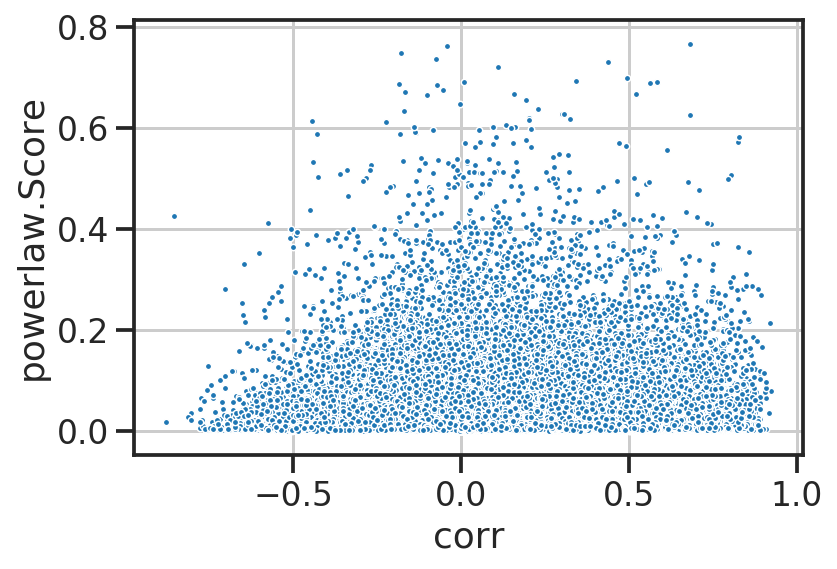

In [33]:
fig, ax = plt.subplots()
sns.scatterplot(x='corr', y='powerlaw.Score', data=merged, s=10, ax=ax)
plt.show()

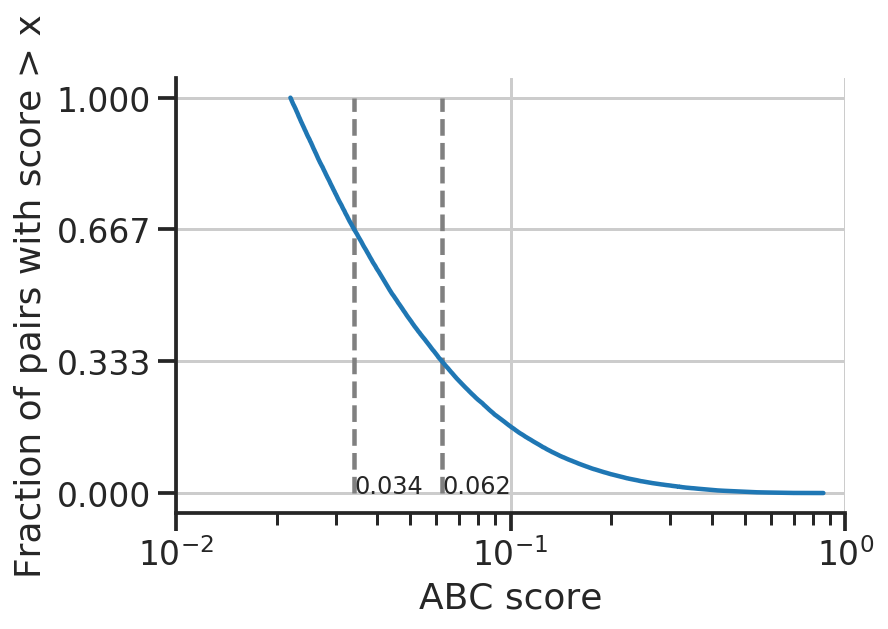

In [34]:
fig, ax = plt.subplots()
x, y = powerplot.gen_cdf(abc['powerlaw.Score'][cond_sigabc], ax=ax, flip=True,)

ax.vlines(bins[1:-1], 0, 1, linestyle='--', color='grey')
for _x in bins[1:-1]:
    ax.text(_x, 0, "{:.2g}".format(_x), fontsize=12)

sns.despine(ax=ax)
ax.set_xlabel('ABC score')
ax.set_ylabel('Fraction of pairs with score > x')
ax.set_yticks([0, 1/3, 2/3, 1])
ax.set_xscale('log')
ax.set_xlim([0.01, 1])
plt.show()

### TODO: remove promoters? 

In [35]:
abc.groupby('abc_cat').size()

abc_cat
1-low     21481
2-mid     21481
3-high    21479
dtype: int64

In [36]:
highset = abc[((abc['abc_cat']=='3-high') & (abc['class']!='promoter'))][['enh_name', 'TargetGene']]
highset = set(highset['TargetGene'].str.cat(highset['enh_name'], sep=',').tolist()) 
print(len(highset))

midset = abc[((abc['abc_cat']=='2-mid') & (abc['class']!='promoter'))][['enh_name', 'TargetGene']]
midset = set(midset['TargetGene'].str.cat(midset['enh_name'], sep=',').tolist()) 
print(len(midset))

lowset = abc[((abc['abc_cat']=='1-low') & (abc['class']!='promoter'))][['enh_name', 'TargetGene']]
lowset = set(lowset['TargetGene'].str.cat(lowset['enh_name'], sep=',').tolist()) 
print(len(lowset))

resset = set(res2_stats['linked_table']['gene'].str.cat(res2_stats['linked_table']['enh_name'], sep=',').tolist())
print(len(resset))

20849
21266
21325
8769


/cndd2/fangming/projects/scf_enhancers/enhancer_metacells_r100_n935/figures/fig2_metacell_210721_r25.1_n256_ven_pairs_correlated.pdf


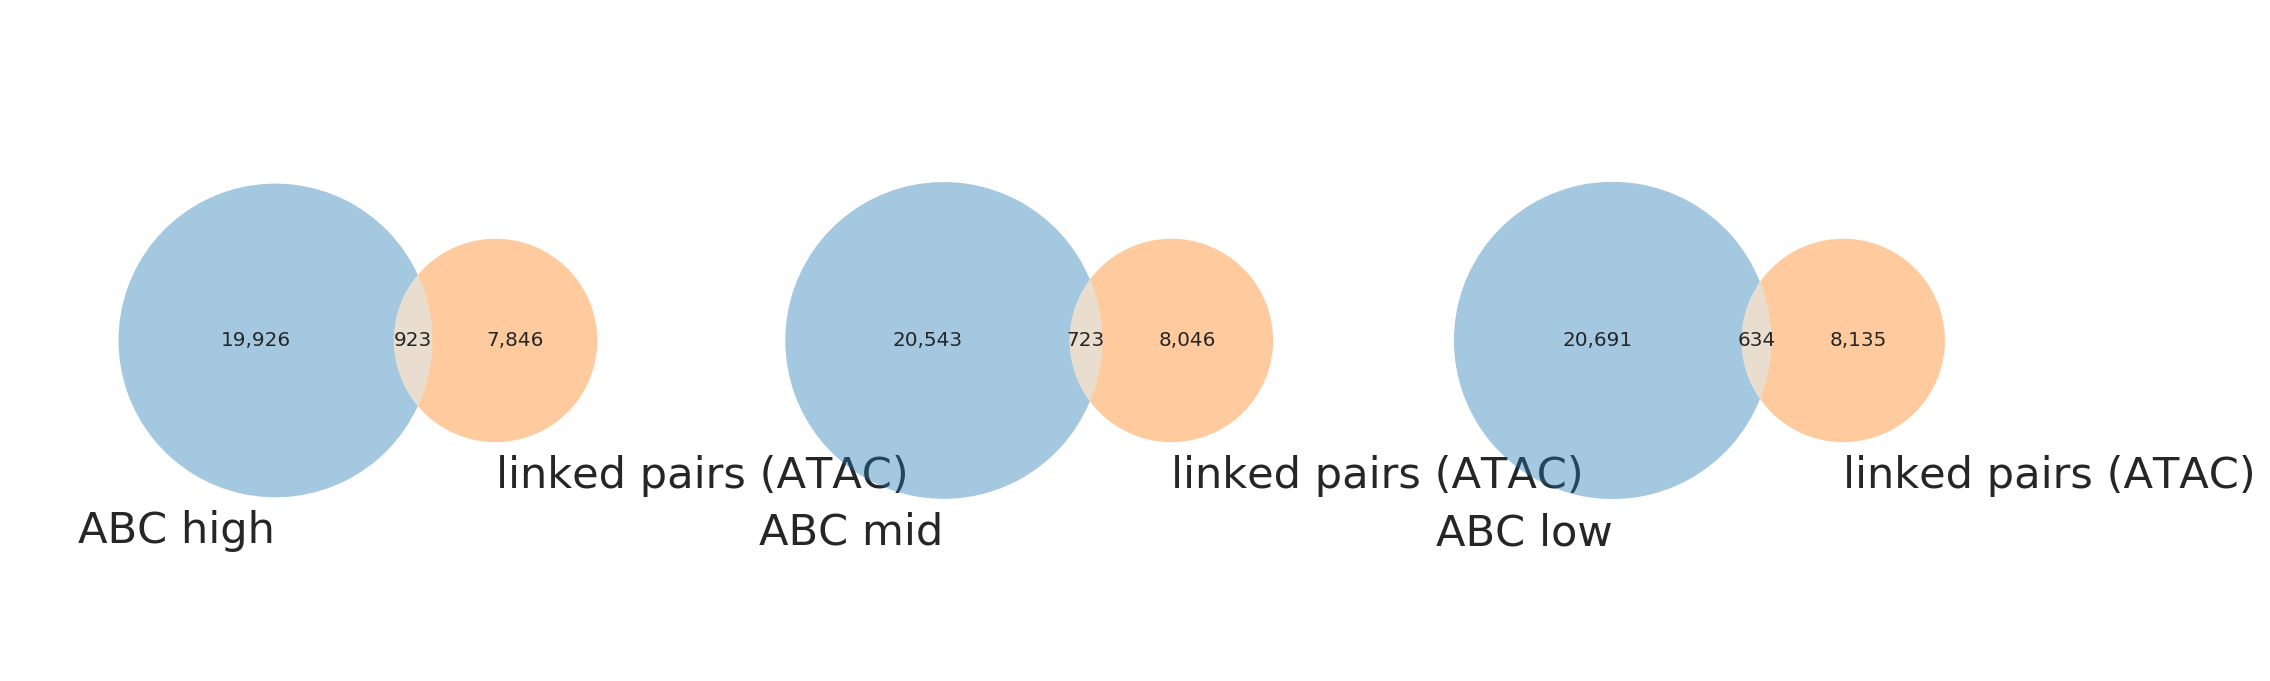

In [37]:
output = output_figures.format('ven_pairs_correlated.pdf')

title = ''

ref_area = len(highset|resset)

fig, axs = plt.subplots(1,3,figsize=(3*6,1*6))
ax = axs[0]
venn_ax(ax, title, 
        [highset, resset], 
        ['ABC high', 'linked pairs (ATAC)'], 
        ['C0', 'C1'], 
       )
true_area = len(highset|resset)
enhancer_gene_utils.set_venn_scale(ax, true_area, ref_area)

ax = axs[1]
venn_ax(ax, title, 
        [midset, resset], 
        ['ABC mid', 'linked pairs (ATAC)'], 
        ['C0', 'C1'],
       )
true_area = len(midset|resset)
enhancer_gene_utils.set_venn_scale(ax, true_area, ref_area)

ax = axs[2]
venn_ax(ax, title, 
        [lowset, resset], 
        ['ABC low', 'linked pairs (ATAC)'], 
        ['C0', 'C1'],
       )
true_area = len(lowset|resset)
enhancer_gene_utils.set_venn_scale(ax, true_area, ref_area)

fig.subplots_adjust(wspace=0)
print(output)
snmcseq_utils.savefig(fig, output)
